lets pull the latest catalog of exoplanets from https://exoplanetarchive.ipac.caltech.edu/index.html

compare them to the various novae/SN lists we might come up with

check: are any of these exoplanets close to an ellipsoid edge? (maybe with a couple years?)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from astropy import constants as const
import astropy.coordinates as coord
from astropy.table import Table

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# Pfile = 'PS_2021.04.13_12.25.05.csv'
# planetary systems table:
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS&constraint=default_flag=1
Pfile = 'PS_2021.04.19_17.09.05.csv'

df = pd.read_csv(Pfile, comment='#')

df.shape

/Users/james/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(29387, 287)

In [4]:
# TESS project candidates
# https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=TOI
Tfile = 'TOI_2021.04.19_17.09.56.csv'
dfT = pd.read_csv(Tfile, comment='#')

dfT.shape

(2645, 87)

In [55]:
# dfT['st_dist']
# okT = np.isfinite(dfT['st_dist'] )
# plt.scatter(dfT['ra'][okT], dfT['dec'][okT],s=10, alpha=0.5)
# sum(okT)

In [56]:
# dfT['tid'][okT].unique().size

In [54]:
# dfT.columns

# df['soltype'].unique()

In [57]:
# how many unique star systems can we explore?
# df['gaia_id'].unique().size

In [58]:
# how many unique star systems with good distances?
# df['gaia_id'][np.isfinite(df['sy_dist'])].unique().size

In [5]:
# use Pandas GroupBy & First to select only unique Gaia IDs (the first entries)
stars1 = df.groupby('gaia_id',as_index=False).first()

stars2 = dfT.groupby('tid',as_index=False).first()

print(sum(np.isfinite(stars1['sy_dist'])), 
      sum(np.isfinite(stars2['st_dist'])))

3039 2482


so this is actually the first real workflow shakedown! Real stars + real sources!

1. Prep Sources (Novae)
- read in list(s)
- put into same structures for matching

2. Prep the Stars:
- put ra,dec,dist into 3D SkyCoord object w/ units
- Time into astropy.Time object w/ units


3. Compute the Ellipse Positions
- full 3D distances, thank you astropy for doing this 
- then dsitances math from before... need to name this step better


In [6]:
# 1.
def make_objects(ra,dec,dist, Y, M, D):
    cc = SkyCoord(ra=ra, dec=dec, distance=dist)

    tt = Time({'year':Y, 'month':M, 'day':D}, 
              format='ymdhms')

    return cc,tt

def pull_sources(file='SOURCES_20210419.csv'):
    '''
    A simple wrapper to pull the "sources", aka the novae/SNe/original
    events as WE observed them, and put them into astropy structures.
    
    TO DO: sure wish we had errors, esp. on distance...
    '''
    src = pd.read_csv(file)

    cc, tt = make_objects(src['RA'].values*u.deg, 
                          src['Dec'].values*u.deg, 
                          src['dist'].values*u.pc, 
                          src['year'].astype('int').values, 
                          src['month'].astype('int').values, 
                          src['day'].astype('int').values)
    return cc, tt

cc_S, tt_S = pull_sources() # the event "sources"

/Users/james/opt/anaconda3/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 105 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [9]:
# 2.
Sok1 = np.where(np.isfinite(stars1['sy_dist']))[0]
Sok2 = np.where(np.isfinite(stars2['st_dist']))[0]

# Coordinates for the stars/objects to monitor
cc_O = SkyCoord(ra=np.concatenate((stars1['ra'][Sok1].values, 
                                   stars2['ra'][Sok2].values)) * u.deg, 
                dec=np.concatenate((stars1['dec'][Sok1].values,
                                    stars2['dec'][Sok2].values)) * u.deg, 
                distance=np.concatenate((stars1['sy_dist'][Sok1].values,
                                         stars2['st_dist'][Sok2].values)) * u.pc)

# Times are... whatever we decide to observe over!
# * in the case of the ZTF "stream" they are the alert times, and match
#   1-to-1 with the coordinates
#
# * in the case of TESS data they might be the start/stop times of Sectors
#   that each source was oberved in (e.g. from the Web Viewing Tool)
#   https://heasarc.gsfc.nasa.gov/cgi-bin/tess/webtess/wtv.py
#
# * in the case of a proposal... let's just do 1 datapoint per year right now,
#   since that == 1 Lyr of distance within the SETI Ellipsoid

# tt_0 = Time( {'year':np.zeros(len(tt_0)) + 2021, 
#               'month':np.zeros(len(tt_0)) + 1, 
#               'day':np.zeros(len(tt_0)) + 1}, format='ymdhms')

2656
1423


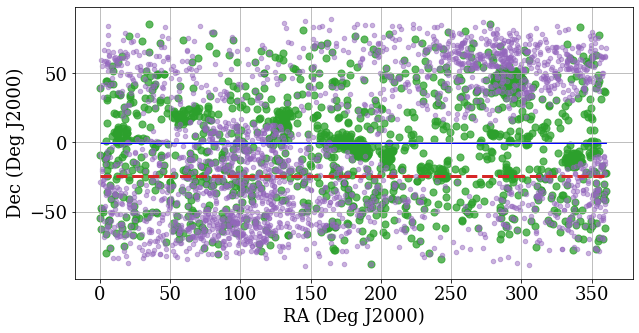

In [133]:
plt.figure(figsize=(10,5))

plt.scatter(stars1['ra'][Sok1].values, stars1['dec'][Sok1].values, c='C2', s=50, alpha=0.75)
plt.scatter(stars2['ra'][Sok2].values, stars2['dec'][Sok2].values, c='C4', s=20, alpha=0.5)

plt.plot([0,361], [-24.5, -24.5], c='C3', lw=3, linestyle='dashed')

plt.fill_between([0,360],[0.54,0.54], y2=[-0.54, -0.54], color='b')

plt.xlabel('RA (Deg J2000)')
plt.ylabel('Dec (Deg J2000)')
plt.grid(True)
plt.savefig('planets_radec.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

print(sum(stars1['dec'][Sok1].values > -25))
print(sum(stars2['dec'][Sok2].values > -25))

In [132]:
print(sum(stars1['dec'][Sok1].values > -25) + sum(stars2['dec'][Sok2].values > -25))
print(sum(stars1['dec'][Sok1].values > -25) + sum(stars2['dec'][Sok2].values > -25))

4079


In [131]:
# exoplanets in the Earth Transit Zone
print(sum(np.abs(stars1['dec'][Sok1].values) < 0.54)/ len(stars1['dec'][Sok1].values))
print(sum(np.abs(stars2['dec'][Sok2].values) < 0.54)/ len(stars2['dec'][Sok2].values))

print(sum(np.abs(stars1['dec'][Sok1].values) < 0.54))
print(sum(np.abs(stars2['dec'][Sok2].values) < 0.54))



0.006910167818361303
0.0060435132957292505
21
15


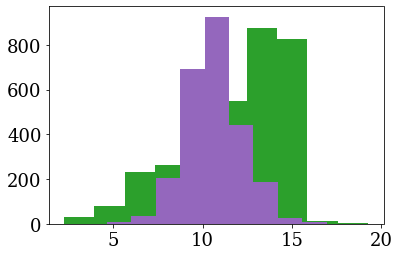

In [126]:
# stars1.columns.values
_ = plt.hist(stars1['sy_tmag'], color='C2')
_ = plt.hist(stars2['st_tmag'], color='C4')         

In [79]:
j = 2019
tt_0 = Time( {'year':np.zeros(len(cc_O), dtype=int) + j, 
              'month':np.zeros(len(cc_O), dtype=int) + 1, 
              'day':np.zeros(len(cc_O), dtype=int) + 1}, format='ymdhms')
len(cc_O)


5523

In [136]:
# 3.

etol = 1. # ellipse tolerance (in lyr) (1 year for now... )
print('yr', '<0.07lyr', '<0.1lyr', '<1lyr')

# try a few years, just for an example
for j in (range(2019,2025)):
    tt_0 = Time( {'year':np.zeros(len(cc_O), dtype=int) + j, 
                  'month':np.zeros(len(cc_O), dtype=int) + 1, 
                  'day':np.zeros(len(cc_O), dtype=int) + 1}, format='ymdhms')

    # the smaller list is the novae/sources... 
    # loop over each Source, compute the ellipsoid distance to each star
    look1 = 0 
    look2 = 0
    look3 = 0
    
    # Rsymb
    for k in range(tt_S.size):
        # time diff from Source[k] to all Stars/Objects
        # should be positive, for Novae in the past
        dt = tt_0 - tt_S[k]

        c = cc_S[k].distance.to('lyr') / 2 # the Source[k] foci distance
        a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of Source[k] ellipse
        d2 = cc_O.separation_3d(cc_S[k]) # 3D dist between Source[k] and the Stars/Objects

        # the ellipsoid surface distance
        Edist = (cc_O.distance.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)

        # we should LOOK at sources if they are near the ellipsoid edges
        # (and if they have positive dt)
        look = (np.abs(Edist) < etol)  & (dt > 0)
        look1 += sum((np.abs(Edist) < 0.07)  & (dt > 0)) # try different thresholds
        look2 += sum((np.abs(Edist) < 0.1)  & (dt > 0))
        look3 += sum((np.abs(Edist) < 1.0)  & (dt > 0))

        # print the SN1987A results for each year
        if (tt_S[k].value[0] == 1987) & (tt_S[k].value[1] == 2):
            print('SN1987A, <0.07lyr: ', sum((np.abs(Edist) < 0.1)  & (dt > 0)))
            
    #     print(k, tt_S[k], sum(look))
    print(j, look1, look2, look3)
    print('')

yr <0.07lyr <0.1lyr <1lyr
SN1987A, <0.07lyr:  2
2019 197 281 2932

SN1987A, <0.07lyr:  1
2020 210 295 2912

SN1987A, <0.07lyr:  0
2021 232 341 3056

SN1987A, <0.07lyr:  1
2022 198 286 2997

SN1987A, <0.07lyr:  2
2023 218 310 3007

SN1987A, <0.07lyr:  3
2024 197 281 3103



In [127]:
(341+ 286 + 310 + 281) / 4

304.5

In [25]:
## VASCO illustration

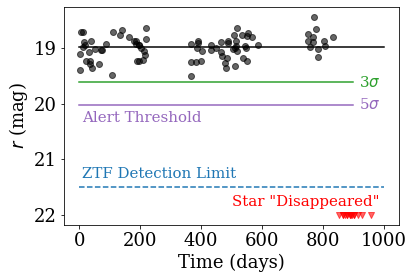

In [98]:
Npts = 100
time = np.random.random(Npts)*230 + np.random.choice([0,1,2], size=Npts)*365
flux = np.random.normal(loc=19., scale=0.2, size=Npts)

std = np.std(flux)
men = np.mean(flux)

flux[time > 850] = 22

plt.scatter(time[flux < 21], flux[flux < 21], c='k', alpha=0.6)
plt.plot([0,1000], [men,men], c='k')
plt.plot([0,900], [men+3*std,men+3*std], c='C2')
plt.plot([0,900], [men+5*std,men+5*std], c='C4')
plt.text(920, 19.7, r'3$\sigma$', fontsize=15, color='C2')
plt.text(920, 20.1, r'5$\sigma$', fontsize=15, color='C4')
plt.text(10, 20.33, 'Alert Threshold', fontsize=15, c='C4')

plt.plot([0,1000], [21.5, 21.5], linestyle='--', c='C0')
plt.text(10, 21.33, 'ZTF Detection Limit', fontsize=15, c='C0')

plt.scatter(time[flux > 21], flux[flux > 21], c='r', alpha=0.6, marker='v')

plt.text(500, 21.85, 'Star "Disappeared"', fontsize=15, c='r')
plt.xlabel('Time (days)')
plt.ylabel('$r$ (mag)')
plt.gca().invert_yaxis()

plt.savefig('VASCO_cartoon.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)